In [6]:
! pip install kaggle

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [00:45<00:00, 29.7MB/s]
100% 3.10G/3.10G [00:46<00:00, 72.3MB/s]


In [11]:
! unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [12]:
#Up until this point we imported and unzipped the data from kaggle.
#Imports 
import numpy as np
import glob
import random
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt

from PIL import Image

#Seeding for the random function used later.
random.seed(98)
np.random.seed(98)

In [13]:
#Adding all the images to an array.
breast_img = glob.glob('IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

IDC_regular_ps50_idx5/9322/1/9322_idx5_x2551_y1251_class1.png
IDC_regular_ps50_idx5/9322/1/9322_idx5_x2951_y1251_class1.png
IDC_regular_ps50_idx5/9322/1/9322_idx5_x2751_y1201_class1.png


In [15]:
non_img = [] #no-cancer
can_img = [] #cancer

#Dividing the data into 2 categories: IDC negative and IDC positive.
for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)
    
    elif img[-5] == '1' :
        can_img.append(img)

#Reducing the data by third in order to decrease run time.
non_img = non_img[:len(non_img)//3]
can_img = can_img[:len(can_img)//3]

In [16]:
#Printing the number of images.
non_num = len(non_img)
can_num = len(can_img)
        
total_img_num = non_num + can_num
        
print('Number of Images in IDC (-): {}' .format(non_num))
print('Number of Images in IDC (+) : {}' .format(can_num))
print('Total Number of Images : {}' .format(total_img_num))

Number of Images in IDC (-): 66246
Number of Images in IDC (+) : 26262
Total Number of Images : 92508


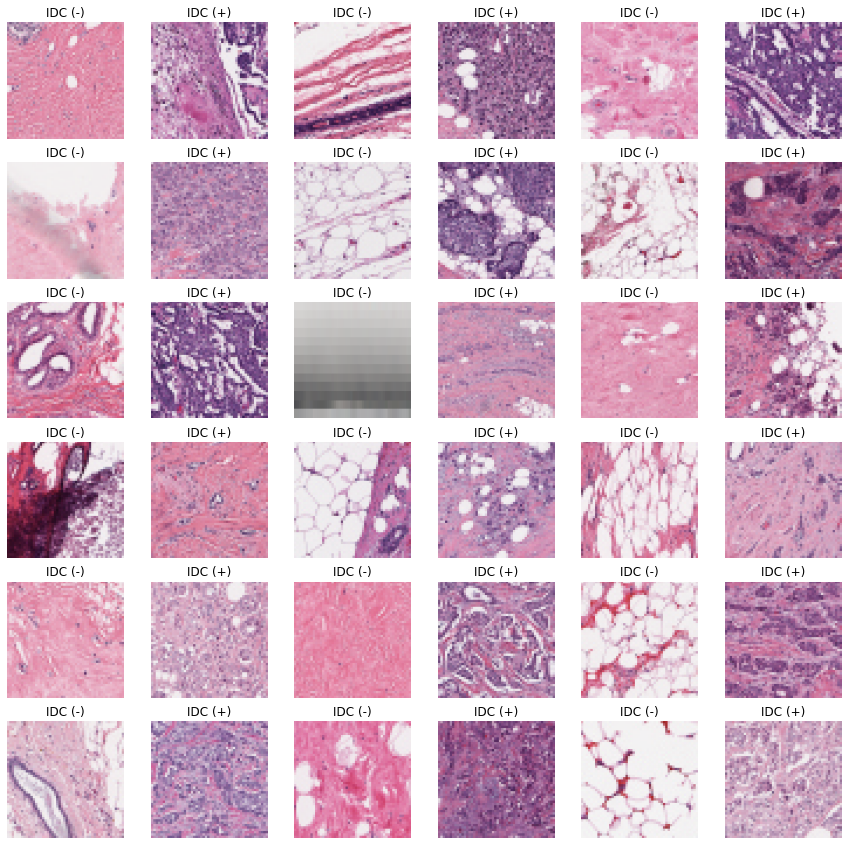

In [17]:
#Plotting some examples of the data.
from keras.preprocessing import image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_img), 18)
some_can = np.random.randint(0, len(can_img), 18)

s = 0
for num in some_non:
    
        img = image.load_img((non_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_can:
    
        img = image.load_img((can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [18]:
#Resizing all the images to be 50x50 pixels.
from matplotlib.image import imread
import cv2

some_non_img = random.sample(non_img, len(can_img))
some_can_img = random.sample(can_img, len(can_img))

non_img_arr = []
can_img_arr = []

for img in some_non_img:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in some_can_img:
    
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])    

In [19]:
#Combining the 2 arrays into one and dividing the X paramaters and the target(y).
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print('X shape : {}' .format(X.shape))

X shape : (52524, 50, 50, 3)


In [20]:
#Dividing the data: 50% goes to training, 20% goes to validation and 30% goes for test.
#We also convert the categorial labels(y) into a vector of 2 numbers using one hot encoding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

rate = 0.5
num = int(X.shape[0] * rate)

X_val = X_train[num:]
X_train = X_train[:num]

y_val = y_train[num:]
y_train = y_train[:num]
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_val = to_categorical(y_val, 2)

print('X_train shape : {}' .format(X_train.shape))
print('X_val shape : {}' .format(X_val.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_val shape : {}' .format(y_val.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (26262, 50, 50, 3)
X_val shape : (10504, 50, 50, 3)
X_test shape : (15758, 50, 50, 3)
y_train shape : (26262, 2)
y_val shape : (10504, 2)
y_test shape : (15758, 2)


In [21]:
#Bulding the base model: using 3 layers of 32,32,32 with padding and max pooling.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(2, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 32)                1

In [22]:
#Compiling the model using loss of binary crossentropy
#and the Adam optimizer which according to https://arxiv.org/abs/1412.6980 the method is "computationally efficient, has little memory requirement,
#invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".
#the metric we're looking at is accuracy.
from tensorflow.keras.optimizers import Adam

Adam = Adam(learning_rate = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

In [23]:
#Running the model with 30 epochs and batch size of 50.
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 30, batch_size = 50)

Epoch 1/30
526/526 [==============================] - 17s 14ms/step - loss: 0.6324 - accuracy: 0.8607 - val_loss: 0.3674 - val_accuracy: 0.8747
Epoch 2/30
526/526 [==============================] - 6s 12ms/step - loss: 0.3256 - accuracy: 0.8817 - val_loss: 0.2956 - val_accuracy: 0.8848
Epoch 3/30
526/526 [==============================] - 7s 13ms/step - loss: 0.2890 - accuracy: 0.8890 - val_loss: 0.2887 - val_accuracy: 0.8880
Epoch 4/30
526/526 [==============================] - 6s 12ms/step - loss: 0.2723 - accuracy: 0.8956 - val_loss: 0.2737 - val_accuracy: 0.8913
Epoch 5/30
526/526 [==============================] - 7s 13ms/step - loss: 0.2658 - accuracy: 0.8966 - val_loss: 0.2659 - val_accuracy: 0.8940
Epoch 6/30
526/526 [==============================] - 6s 12ms/step - loss: 0.2529 - accuracy: 0.9031 - val_loss: 0.2762 - val_accuracy: 0.8913
Epoch 7/30
526/526 [==============================] - 6s 12ms/step - loss: 0.2440 - accuracy: 0.9069 - val_loss: 0.2780 - val_accuracy: 0.891

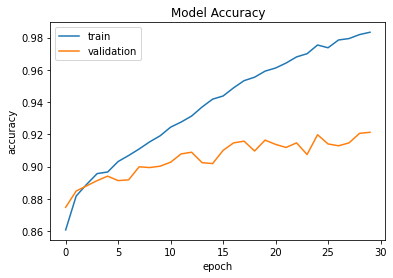

In [24]:
#Plotting the model accuracy.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

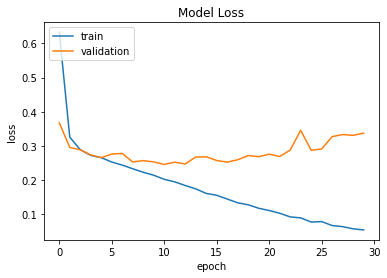

In [25]:
#Plotting the model loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
#Evaluating the model results on the test data.
result = model.evaluate(X_test, y_test, batch_size = 50)
print('Test Loss, Test Accuracy :', result)

316/316 [==============================] - 2s 6ms/step - loss: 0.3507 - accuracy: 0.9189
Test Loss, Test Accuracy : [0.35071471333503723, 0.918898344039917]


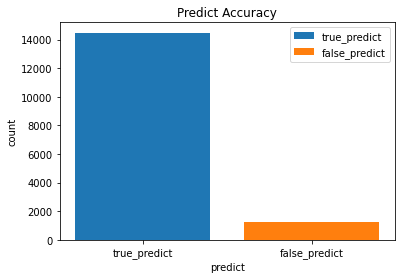

In [27]:
#Plotting the number of times the model was right/wrong on the test data.
import seaborn as sns

P = model.predict(X_test)

true = 0
for i in range(X_test.shape[0]):
    if(np.argmax(P[i]) == np.argmax(y_test[i])):
        true = true + 1

false = len(X_test) - true

predict = [true, false]
label = ['true_predict', 'false_predict']

plt.bar(label[0], predict[0])
plt.bar(label[1], predict[1])
plt.title('Predict Accuracy')
plt.xlabel('predict')
plt.ylabel('count')
plt.legend(['true_predict', 'false_predict'], loc='upper right')
plt.show()